In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
sns.set()

In [35]:
import configparser
config = configparser.ConfigParser()

In [36]:
import os
current_working_directory = os.getcwd()
#print(current_working_directory)
new_directory = "/Users/ananyasai/ds5001"  
os.chdir(new_directory)

In [37]:
config.read("env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
LIB = pd.read_csv(f"{output_dir}/tamilnet-LIB.csv")
CORPUS = pd.read_csv(f'{output_dir}/tamilnet-CORPUSS.csv')
VOCAB = pd.read_csv(f'{output_dir}/tamilnet-VOCAB.csv').set_index('term_str').dropna()

In [38]:
CORPUS_reset = CORPUS.reset_index()
CORPUS_reset.head()

,index,doc_id,doc_ord,doc_content,term_str,pos,pos_group,doc_uri,doc_title
0,0,1.0,1997.0,the sri lankan army has launched another recru...,sri,NN,Noun,https://www.tamilnet.com/art.html?catid=13&art...,Sri Lanka army launches another recruitment drive
1,1,1.0,1997.0,the sri lankan army has launched another recru...,lankan,JJ,Adjective,https://www.tamilnet.com/art.html?catid=13&art...,Sri Lanka army launches another recruitment drive
2,2,1.0,1997.0,the sri lankan army has launched another recru...,army,NN,Noun,https://www.tamilnet.com/art.html?catid=13&art...,Sri Lanka army launches another recruitment drive
3,3,1.0,1997.0,the sri lankan army has launched another recru...,launched,VBN,Verb,https://www.tamilnet.com/art.html?catid=13&art...,Sri Lanka army launches another recruitment drive
4,4,1.0,1997.0,the sri lankan army has launched another recru...,another,DT,Other,https://www.tamilnet.com/art.html?catid=13&art...,Sri Lanka army launches another recruitment drive


In [39]:
BOW = CORPUS_reset.groupby(['doc_id','doc_content', 'pos_group'])['term_str'].count().to_frame()
DTCM = BOW.unstack().fillna(0)
#doc_content as seen before does not have punctuation that could make it split reasonably into sentences or smaller chunks. also, doing it by term made the kernel crash. hence, this is the best way forward

In [40]:
BOW.columns

Index(['term_str'], dtype='object')

In [41]:
BOW.head()

term_str
doc_id doc_content                                        pos_group          
1.0    the sri lankan army has launched another recrui... Adjective        83
                                                          Adverb           21
                                                          Noun            189
                                                          Other             9
                                                          Verb            102

In [42]:
DTCM.head()

term_str         \
pos_group                                                 Adjective Adverb   
doc_id doc_content                                                           
1.0    the sri lankan army has launched another recrui...      83.0   21.0   
2.0    latest reports coming from thandikulam in the n...      53.0   13.0   
3.0    as the battle for control of a key town in the ...      39.0    9.0   
4.0    when tamil tiger commandos stormed the sri lank...      71.0   42.0   
5.0    french essayist and philosopher paul valery whe...      45.0   13.0   

                                                                               
pos_group                                                   Noun Other   Verb  
doc_id doc_content                                                             
1.0    the sri lankan army has launched another recrui...  189.0   9.0  102.0  
2.0    latest reports coming from thandikulam in the n...  179.0  12.0   77.0  
3.0    as the battle for control of a key town in the ...  104.0   6.0   46.0  
4.0    when tamil tiger commandos stormed the sri lank...  270.0  13.0  143.0  
5.0    french essayist and philosopher paul valery whe...  136.0   5.0   47.0

In [43]:
def create_tfidf(bow, tf_method):
    
    N = bow.shape[0]
    
    #for tf
    if tf_method == 'sum':
        TF = bow.T / bow.T.sum()
    elif tf_method == 'max':
        TF = bow.T / bow.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + bow.T)
    elif tf_method == 'raw':
        TF = bow.T
    elif tf_method == 'double_norm':
        TF = bow.T / bow.T.max()
    elif tf_method == 'binary':
        TF = bow.T.astype('bool').astype('int')
    TF = TF.T
    
    #df
    DF = bow.astype('bool').sum() 
    
    #for idf
    IDF = np.log2(N / DF)
    
    #for tfidf
    TFIDF = TF * IDF
    
    #for dfidf
    DFIDF = DF * np.log2(N / DF)
    
    return TFIDF, DFIDF

In [44]:
tfidf, dfidf = create_tfidf(DTCM, 'binary')

In [45]:
tfidf.head()

term_str            \
pos_group                                                 Adjective    Adverb   
doc_id doc_content                                                              
1.0    the sri lankan army has launched another recrui...  0.000398  0.188435   
2.0    latest reports coming from thandikulam in the n...  0.000398  0.188435   
3.0    as the battle for control of a key town in the ...  0.000398  0.188435   
4.0    when tamil tiger commandos stormed the sri lank...  0.000398  0.188435   
5.0    french essayist and philosopher paul valery whe...  0.000398  0.188435   

                                                                               
pos_group                                                 Noun     Other Verb  
doc_id doc_content                                                             
1.0    the sri lankan army has launched another recrui...  0.0  0.090061  0.0  
2.0    latest reports coming from thandikulam in the n...  0.0  0.090061  0.0  
3.0    as the battle for control of a key town in the ...  0.0  0.090061  0.0  
4.0    when tamil tiger commandos stormed the sri lank...  0.0  0.090061  0.0  
5.0    french essayist and philosopher paul valery whe...  0.0  0.090061  0.0

In [46]:
VOCAB.head()

,n,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos
term_str,,,,,,,
aa,2,NN,Noun,1,{'Noun'},1,{'NN'}
aaa,8,JJ,Adjective,4,"{'Noun', 'Verb', 'Other', 'Adjective'}",4,"{'VB', 'NN', 'JJ', 'PDT'}"
aaadupaddi,1,JJ,Adjective,1,{'Adjective'},1,{'JJ'}
aaanaikaddiyaveli,2,JJ,Adjective,1,{'Adjective'},1,{'JJ'}
aaanaikkoaddai,2,NN,Noun,1,{'Noun'},1,{'NN'}


In [47]:
dfidf.head()

          pos_group
term_str  Adjective      12.982466
          Adverb       5399.411163
          Noun            0.000000
          Other        2762.710858
          Verb            0.000000
dtype: float64

In [48]:
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)


In [49]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/ananyasai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ananyasai/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ananyasai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ananyasai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')
VOCAB[VOCAB.stop == 1].sample(10)

,n,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,p,i,stop
term_str,,,,,,,,,,
don,2,NNS,Noun,1,{'Noun'},1,{'NNS'},4.058984e-07,21.232378,1
as,2,NN,Noun,1,{'Noun'},1,{'NN'},4.058984e-07,21.232378,1
s,15,NN,Noun,2,"{'Noun', 'Adjective'}",3,"{'NNS', 'NN', 'JJ'}",3.044238e-06,18.325487,1
at,4,NNS,Noun,2,"{'Noun', 'Adjective'}",2,"{'NNS', 'JJ'}",8.117969e-07,20.232378,1
he,15,NNS,Noun,2,"{'Noun', 'Verb'}",2,"{'NNS', 'VBZ'}",3.044238e-06,18.325487,1
o,2,NN,Noun,1,{'Noun'},1,{'NN'},4.058984e-07,21.232378,1
an,2,NNS,Noun,1,{'Noun'},1,{'NNS'},4.058984e-07,21.232378,1
m,5329,NN,Noun,5,"{'Adverb', 'Noun', 'Adjective', 'Verb', 'Other'}",16,"{'RBR', 'VBD', 'RBS', 'FW', 'VB', 'RB', 'JJS',...",1.081516e-03,9.852729,1
y,1,NN,Noun,1,{'Noun'},1,{'NN'},2.029492e-07,22.232378,1


In [51]:
VOCAB_n = VOCAB.reset_index()
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB_n['stem_porter'] = VOCAB_n['term_str'].astype(str).apply(lambda x: stemmer1.stem(x))
VOCAB_n.set_index('term_str')

,n,max_pos,max_pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,p,i,stop,stem_porter
term_str,,,,,,,,,,,
aa,2,NN,Noun,1,{'Noun'},1,{'NN'},4.058984e-07,21.232378,0,aa
aaa,8,JJ,Adjective,4,"{'Noun', 'Verb', 'Other', 'Adjective'}",4,"{'VB', 'NN', 'JJ', 'PDT'}",1.623594e-06,19.232378,0,aaa
aaadupaddi,1,JJ,Adjective,1,{'Adjective'},1,{'JJ'},2.029492e-07,22.232378,0,aaadupaddi
aaanaikaddiyaveli,2,JJ,Adjective,1,{'Adjective'},1,{'JJ'},4.058984e-07,21.232378,0,aaanaikaddiyav
aaanaikkoaddai,2,NN,Noun,1,{'Noun'},1,{'NN'},4.058984e-07,21.232378,0,aaanaikkoaddai
...,...,...,...,...,...,...,...,...,...,...,...
ørbeck,3,NNP,Noun,1,{'Noun'},1,{'NNP'},6.088477e-07,20.647415,0,ørbeck
øverland,1,NN,Noun,1,{'Noun'},1,{'NN'},2.029492e-07,22.232378,0,øverland
øvind,1,NNP,Noun,1,{'Noun'},1,{'NNP'},2.029492e-07,22.232378,0,øvind


In [52]:
VOCAB_n = VOCAB_n.rename(columns={'max_pos_group': 'pos_group'})
dfidf_reset = dfidf.reset_index()
VOCAB_combined = VOCAB_n.merge(dfidf_reset, on='pos_group', how='left')


In [53]:
VOCAB_combined.set_index("term_str")

,n,max_pos,pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,p,i,stop,stem_porter,level_0,0
term_str,,,,,,,,,,,,,
aa,2,NN,Noun,1,{'Noun'},1,{'NN'},4.058984e-07,21.232378,0,aa,term_str,0.000000
aaa,8,JJ,Adjective,4,"{'Noun', 'Verb', 'Other', 'Adjective'}",4,"{'VB', 'NN', 'JJ', 'PDT'}",1.623594e-06,19.232378,0,aaa,term_str,12.982466
aaadupaddi,1,JJ,Adjective,1,{'Adjective'},1,{'JJ'},2.029492e-07,22.232378,0,aaadupaddi,term_str,12.982466
aaanaikaddiyaveli,2,JJ,Adjective,1,{'Adjective'},1,{'JJ'},4.058984e-07,21.232378,0,aaanaikaddiyav,term_str,12.982466
aaanaikkoaddai,2,NN,Noun,1,{'Noun'},1,{'NN'},4.058984e-07,21.232378,0,aaanaikkoaddai,term_str,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ørbeck,3,NNP,Noun,1,{'Noun'},1,{'NNP'},6.088477e-07,20.647415,0,ørbeck,term_str,0.000000
øverland,1,NN,Noun,1,{'Noun'},1,{'NN'},2.029492e-07,22.232378,0,øverland,term_str,0.000000
øvind,1,NNP,Noun,1,{'Noun'},1,{'NNP'},2.029492e-07,22.232378,0,øvind,term_str,0.000000


In [54]:
top_20_significant_words = VOCAB_combined.sort_values(by=0, ascending=False).head(20)
top_20_significant_words

,term_str,n,max_pos,pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,p,i,stop,stem_porter,level_0,0
34842,lawfully,8,RB,Adverb,1,{'Adverb'},1,{'RB'},1.623594e-06,19.232378,0,law,term_str,5399.411163
70497,undoubtedly,37,RB,Adverb,1,{'Adverb'},1,{'RB'},7.509121e-06,17.022925,0,undoubtedli,term_str,5399.411163
16260,drastically,44,RB,Adverb,1,{'Adverb'},1,{'RB'},8.929766e-06,16.772946,0,drastic,term_str,5399.411163
36861,mainly,405,RB,Adverb,2,"{'Adverb', 'Adjective'}",2,"{'RB', 'JJ'}",8.219443e-05,13.570600,0,mainli,term_str,5399.411163
23669,hereby,41,RB,Adverb,4,"{'Noun', 'Verb', 'Adverb', 'Adjective'}",7,"{'VB', 'RB', 'VBZ', 'VBP', 'JJ', 'NNS', 'NN'}",8.320918e-06,16.874826,0,herebi,term_str,5399.411163
75982,willfully,8,RB,Adverb,1,{'Adverb'},1,{'RB'},1.623594e-06,19.232378,0,will,term_str,5399.411163
16252,dramatically,39,RB,Adverb,1,{'Adverb'},1,{'RB'},7.915019e-06,16.946976,0,dramat,term_str,5399.411163
21373,genuinely,70,RB,Adverb,2,"{'Adverb', 'Adjective'}",2,"{'RB', 'JJ'}",1.420645e-05,16.103095,0,genuin,term_str,5399.411163
1532,agressively,1,RB,Adverb,1,{'Adverb'},1,{'RB'},2.029492e-07,22.232378,0,agress,term_str,5399.411163
41931,naattup,1,RB,Adverb,1,{'Adverb'},1,{'RB'},2.029492e-07,22.232378,0,naattup,term_str,5399.411163


In [55]:
significant_terms_pos = VOCAB_combined.sort_values(by=0, ascending=False)
top_terms_pos = significant_terms_pos.head(1000)

In [56]:
tfidf

term_str  \
pos_group                                                  Adjective   
doc_id  doc_content                                                    
1.0     the sri lankan army has launched another recrui...  0.000398   
2.0     latest reports coming from thandikulam in the n...  0.000398   
3.0     as the battle for control of a key town in the ...  0.000398   
4.0     when tamil tiger commandos stormed the sri lank...  0.000398   
5.0     french essayist and philosopher paul valery whe...  0.000398   
...                                                              ...   
32655.0 opposition leader r sampanthan and pro-establis...  0.000398   
32656.0 nd lead correction as un secretary general ban ...  0.000398   
32657.0 occupying colombos defence ministry has instruc...  0.000398   
32658.0 nd lead adds video a white-van squad has abduct...  0.000398   
32659.0 nd lead corrections executive presidents of the...  0.000398   

                                                                           \
pos_group                                                     Adverb Noun   
doc_id  doc_content                                                         
1.0     the sri lankan army has launched another recrui...  0.188435  0.0   
2.0     latest reports coming from thandikulam in the n...  0.188435  0.0   
3.0     as the battle for control of a key town in the ...  0.188435  0.0   
4.0     when tamil tiger commandos stormed the sri lank...  0.188435  0.0   
5.0     french essayist and philosopher paul valery whe...  0.188435  0.0   
...                                                              ...  ...   
32655.0 opposition leader r sampanthan and pro-establis...  0.188435  0.0   
32656.0 nd lead correction as un secretary general ban ...  0.188435  0.0   
32657.0 occupying colombos defence ministry has instruc...  0.188435  0.0   
32658.0 nd lead adds video a white-van squad has abduct...  0.188435  0.0   
32659.0 nd lead corrections executive presidents of the...  0.188435  0.0   

                                                                           
pos_group                                                      Other Verb  
doc_id  doc_content                                                        
1.0     the sri lankan army has launched another recrui...  0.090061  0.0  
2.0     latest reports coming from thandikulam in the n...  0.090061  0.0  
3.0     as the battle for control of a key town in the ...  0.090061  0.0  
4.0     when tamil tiger commandos stormed the sri lank...  0.090061  0.0  
5.0     french essayist and philosopher paul valery whe...  0.090061  0.0  
...                                                              ...  ...  
32655.0 opposition leader r sampanthan and pro-establis...  0.000000  0.0  
32656.0 nd lead correction as un secretary general ban ...  0.090061  0.0  
32657.0 occupying colombos defence ministry has instruc...  0.090061  0.0  
32658.0 nd lead adds video a white-van squad has abduct...  0.090061  0.0  
32659.0 nd lead corrections executive presidents of the...  0.090061  0.0  

[32652 rows x 5 columns]

In [57]:
top_terms_pos.head()

,term_str,n,max_pos,pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,p,i,stop,stem_porter,level_0,0
34842,lawfully,8,RB,Adverb,1,{'Adverb'},1,{'RB'},0.000002,19.232378,0,law,term_str,5399.411163
70497,undoubtedly,37,RB,Adverb,1,{'Adverb'},1,{'RB'},0.000008,17.022925,0,undoubtedli,term_str,5399.411163
16260,drastically,44,RB,Adverb,1,{'Adverb'},1,{'RB'},0.000009,16.772946,0,drastic,term_str,5399.411163
36861,mainly,405,RB,Adverb,2,"{'Adverb', 'Adjective'}",2,"{'RB', 'JJ'}",0.000082,13.570600,0,mainli,term_str,5399.411163
23669,hereby,41,RB,Adverb,4,"{'Noun', 'Verb', 'Adverb', 'Adjective'}",7,"{'VB', 'RB', 'VBZ', 'VBP', 'JJ', 'NNS', 'NN'}",0.000008,16.874826,0,herebi,term_str,5399.411163


In [58]:
tfidf_reduced = tfidf[('term_str','Adverb')]

In [59]:
cr_tfidf = tfidf.groupby(['doc_id',('term_str', 'Adjective'),
            ('term_str',    'Adverb'),
            ('term_str',      'Noun'),
            ('term_str',     'Other'),
            ('term_str',      'Verb')]).mean()

In [137]:
from numpy.linalg import norm
TFIDF_L2 = cr_tfidf.apply(lambda x: x / norm(x), 1) # Pythagorean, AKA Euclidean

In [138]:
print(TFIDF_L2)
TFIDF_L2

Empty DataFrame
Columns: []
Index: [(1.0, 0.00039771055824255457, 0.18843481410746815, 0.0, 0.09006098767662524, 0.0), (2.0, 0.00039771055824255457, 0.18843481410746815, 0.0, 0.09006098767662524, 0.0), (3.0, 0.00039771055824255457, 0.18843481410746815, 0.0, 0.09006098767662524, 0.0), (4.0, 0.00039771055824255457, 0.18843481410746815, 0.0, 0.09006098767662524, 0.0), (5.0, 0.00039771055824255457, 0.18843481410746815, 0.0, 0.09006098767662524, 0.0), (6.0, 0.00039771055824255457, 0.18843481410746815, 0.0, 0.09006098767662524, 0.0), (7.0, 0.00039771055824255457, 0.18843481410746815, 0.0, 0.09006098767662524, 0.0), (8.0, 0.00039771055824255457, 0.18843481410746815, 0.0, 0.09006098767662524, 0.0), (9.0, 0.00039771055824255457, 0.18843481410746815, 0.0, 0.09006098767662524, 0.0), (10.0, 0.00039771055824255457, 0.18843481410746815, 0.0, 0.09006098767662524, 0.0), (11.0, 0.00039771055824255457, 0.18843481410746815, 0.0, 0.09006098767662524, 0.0), (12.0, 0.00039771055824255457, 0.1884348141074681

doc_id,"(term_str, Adjective)","(term_str, Adverb)","(term_str, Noun)","(term_str, Other)","(term_str, Verb)"
1.0,0.000398,0.188435,0.0,0.090061,0.0
2.0,0.000398,0.188435,0.0,0.090061,0.0
3.0,0.000398,0.188435,0.0,0.090061,0.0
4.0,0.000398,0.188435,0.0,0.090061,0.0
5.0,0.000398,0.188435,0.0,0.090061,0.0
...,...,...,...,...,...
32655.0,0.000398,0.188435,0.0,0.000000,0.0
32656.0,0.000398,0.188435,0.0,0.090061,0.0
32657.0,0.000398,0.188435,0.0,0.090061,0.0
32658.0,0.000398,0.188435,0.0,0.090061,0.0


In [63]:

DTCM.to_csv(f"{output_dir}/tamilnet-DTCM.csv")
VOCAB_combined.to_csv(f"{output_dir}/tamilnet-VOCAB-updated.csv")
BOW.to_csv(f"{output_dir}/tamilnet-BOW.csv")
tfidf.to_csv(f"{output_dir}/tamilnet-tfidf.csv")
TFIDF_L2.to_csv(f"{output_dir}/tamilnet-tfidf-l2.csv")

In [92]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### ORIGINAL PCA
# def compute_pca(X, k, norm_docs, center_by_mean, center_by_variance):
#     if norm_docs:
#         X = (X.T / norm(X, 2, axis=1)).T
    
#     if center_by_mean:
#         X = X - X.mean()
        
#     if center_by_variance:
#         scaler = StandardScaler(with_mean=center_by_mean, with_std=True)
#         X_s = scaler.fit_transform(X)
#         X = pd.DataFrame(X_s, index=X.index, columns=X.columns)
    
#     pca_engine = PCA(n_components=k)
#     DCM = pca_engine.fit_transform(X)
    
#     LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
#     LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
#     LOADINGS.index = X.columns
#     LOADINGS.index.name = 'term_str'
    
#     DCM = pd.DataFrame(pca_engine.fit_transform(X.fillna(0)), index=X.index)
#     DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
#     DCM.index = X.index
#     DCM = DCM.reset_index()
#     DCM = DCM.merge(LIB, on='doc_id', how='left')
#     DCM.set_index(['doc_content',('n', 'Adjective'),
#             ('n',    'Adverb'),
#             ('n',      'Noun'),
#             ('n',     'Other'),
#             ('n',      'Verb')], inplace=True)
#     #DCM['doc'] = DCM.apply(lambda x: f"{x.label} {str(x.name[1]).zfill(2)}", 1)

    
#     COMPINF = pd.DataFrame({
#     'explained_variance': pca_engine.explained_variance_,
#     'explained_variance_ratio': pca_engine.explained_variance_ratio_
# }, index=[f'PC{i+1}' for i in range(k)])
#     return LOADINGS, DCM, COMPINF

### MODIFIED PCA
def compute_pca(X, k, norm_docs=True, center_by_mean=True, center_by_variance=True):
    print("Initial Shape:", X.shape)
    print("Data types:", X.dtypes.unique())

    X.fillna(0, inplace=True)

    if norm_docs:
        X = (X.T / np.linalg.norm(X, axis=1)).T

    if center_by_mean:
        X -= X.mean()

    if center_by_variance:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

    pca_engine = PCA(n_components=k)
    
    DCM = pca_engine.fit_transform(X)

    DCM = pd.DataFrame(DCM, index=X.index, columns=['PC{}'.format(i+1) for i in range(k)])

    LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_), 
                            columns=['PC{}'.format(i+1) for i in range(k)], 
                            index=X.columns)
    LOADINGS.index.name = 'term_str'
    
    COMPINF = pd.DataFrame({
        'explained_variance': pca_engine.explained_variance_,
        'explained_variance_ratio': pca_engine.explained_variance_ratio_
    }, index=['PC{}'.format(i+1) for i in range(k)])

    return LOADINGS, DCM, COMPINF


In [135]:
TFIDF_L2

""
0
1
2
3
4
...
32647
32648
32649
32650


In [172]:

# if isinstance(TFIDF_L2.columns, pd.MultiIndex):
#     TFIDF_L2.columns = ['_'.join(col).strip() for col in TFIDF_L2.columns.values]

TFIDF_L2.reset_index(drop=True, inplace=True)
# TFIDF_L2.fillna(0, inplace=True)
# TFIDF_L2 += 0.00001
# TFIDF_L2 = pd.DataFrame(TFIDF_L2, columns=['doc_id', 'Adjective', 'Adverb', 'Noun', 'Other', 'Verb'])
# try:
#     TFIDF_L2.drop(['index','level_0'], axis=1, inplace=True)
# except:
#     pass
print(TFIDF_L2.columns)
# TFIDF_L2.columns = ['doc_id', 'Adjective', 'Adverb', 'Noun', 'Other', 'Verb']
doc_ids = TFIDF_L2['doc_id'] 
data_for_pca = TFIDF_L2.drop(['doc_id'], axis=1)

print("TFIDF_L2 Shape:", TFIDF_L2.shape)
print("TFIDF_L2 Columns:", TFIDF_L2.columns)
print("TFIDF_L2 Data Types:", TFIDF_L2.dtypes.unique())
L, D, C = compute_pca(TFIDF_L2, 5, True, True, True)
D['doc_id'] = doc_ids
D.set_index('doc_id', inplace=True) 


MultiIndex([(  'doc_id',          ''),
            ('term_str', 'Adjective'),
            ('term_str',    'Adverb'),
            ('term_str',      'Noun'),
            ('term_str',     'Other'),
            ('term_str',      'Verb')],
           name='term_str')
TFIDF_L2 Shape: (32652, 6)
TFIDF_L2 Columns: MultiIndex([(  'doc_id',          ''),
            ('term_str', 'Adjective'),
            ('term_str',    'Adverb'),
            ('term_str',      'Noun'),
            ('term_str',     'Other'),
            ('term_str',      'Verb')],
           name='term_str')
TFIDF_L2 Data Types: [dtype('float64')]
Initial Shape: (32652, 6)
Data types: [dtype('float64')]


/var/folders/sq/7h8lk7x55mj3t69mj22_9t9h0000gn/T/ipykernel_87376/3880513976.py:23: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data_for_pca = TFIDF_L2.drop(['doc_id'], axis=1)  # Drop 'doc_id' from the data to be used in PCA


In [173]:
top_positive_terms_PC1 = L.nlargest(5, 'PC1')['PC1']

top_negative_terms_PC2 = L.nsmallest(5, 'PC2')['PC2']

print("Top 5 positive terms for PC1:", top_positive_terms_PC1)
print("Top 5 negative terms for PC2:", top_negative_terms_PC2)


Top 5 positive terms for PC1:           pos_group
term_str  Other        0.994247
          Adjective    0.994241
          Adverb       0.994232
          Noun        -0.000000
          Verb        -0.000000
Name: PC1, dtype: float64
Top 5 negative terms for PC2:           pos_group
doc_id                -0.337526
term_str  Adjective   -0.106767
          Other       -0.106568
          Adverb      -0.106230
          Noun        -0.000000
Name: PC2, dtype: float64


In [174]:
D.head()

,PC1,PC2,PC3,PC4,PC5
doc_id,,,,,
1.0,295.891918,35.813199,0.014350,0.007688,0.0
2.0,129.332799,-20.118714,-0.027236,-0.014524,-0.0
3.0,81.725285,-22.098024,-0.026336,-0.014145,-0.0
4.0,59.558738,-19.842098,-0.023016,-0.012443,-0.0
5.0,46.798943,-17.442037,-0.020100,-0.010934,-0.0


In [175]:
L.head()

PC1       PC2       PC3       PC4  PC5
         pos_group                                             
doc_id             -0.941333 -0.337526 -0.000015 -0.000005  0.0
term_str Adjective  0.994241 -0.106767  0.006394  0.008725  0.0
         Adverb     0.994232 -0.106230 -0.015709 -0.001016  0.0
         Noun      -0.000000 -0.000000 -0.000000  0.000000  0.0
         Other      0.994247 -0.106568  0.009301 -0.007714  0.0

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], dtype='object')


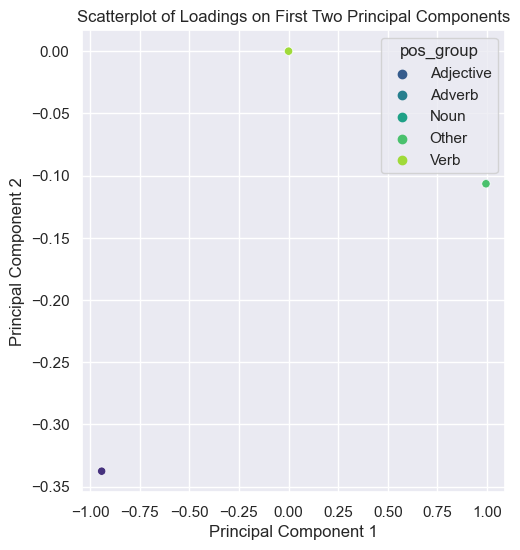

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

print(L.columns)
# if 'term_str' not in L.columns:
#     L.reset_index(drop=True,inplace=True)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', data=L, hue='pos_group', palette='viridis', legend='full')
plt.title('Scatterplot of Loadings on First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

/var/folders/sq/7h8lk7x55mj3t69mj22_9t9h0000gn/T/ipykernel_87376/2715453250.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PC1', y='PC2', data=D, palette='viridis', legend='full')


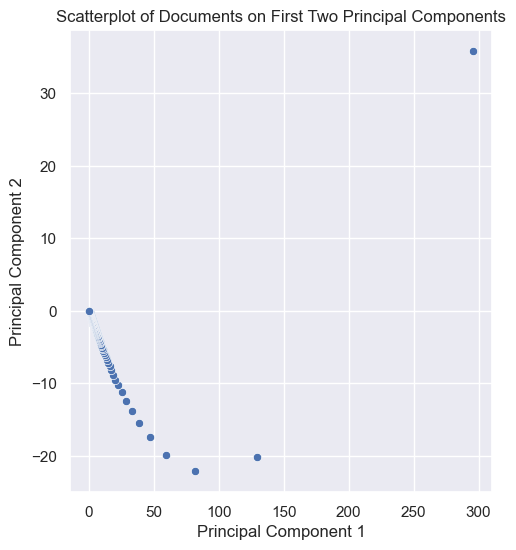

In [179]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', data=D, palette='viridis', legend='full')
plt.title('Scatterplot of Documents on First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

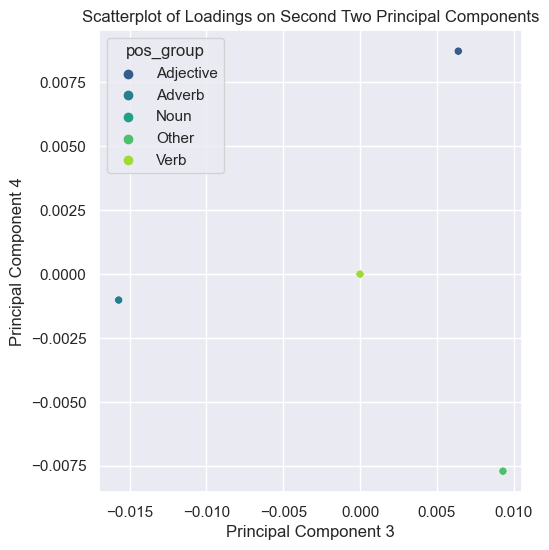

In [180]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot for document scatterplot
sns.scatterplot(x='PC3', y='PC4', data=L, hue='pos_group', palette='viridis', legend='full')
plt.title('Scatterplot of Loadings on Second Two Principal Components')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.show()

/var/folders/sq/7h8lk7x55mj3t69mj22_9t9h0000gn/T/ipykernel_87376/2011746419.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='PC3', y='PC4', data=D, palette='viridis', legend='full')


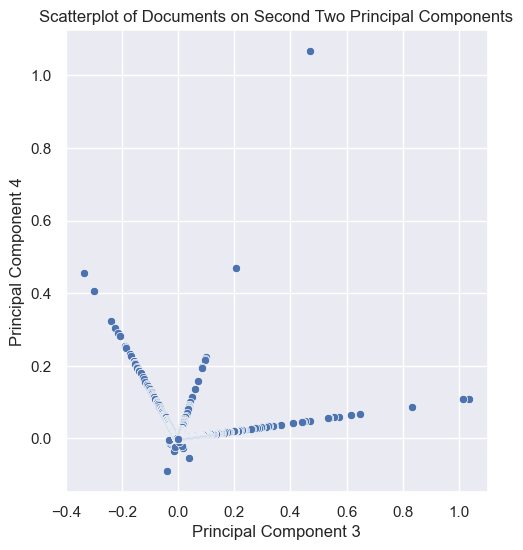

In [181]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) 
sns.scatterplot(x='PC3', y='PC4', data=D, palette='viridis', legend='full')
plt.title('Scatterplot of Documents on Second Two Principal Components')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.show()

In [182]:
BOW.to_csv(f"{output_dir}/tamilnet-BOW.csv")
DTCM.to_csv(f"{output_dir}/tamilnet-DTCM.csv")
tfidf.to_csv(f"{output_dir}/tamilnet-tfidf.csv")
TFIDF_L2.to_csv(f"{output_dir}/tamilnet-tfidf_l2.csv")
L.to_csv(f"{output_dir}/tamilnet-pca_loadings.csv")
D.to_csv(f"{output_dir}/tamilnet-pca_dcm.csv")


In [183]:
filtered_vocab = VOCAB_combined[VOCAB_combined['pos_group'].isin(['Adverb', 'Adjective', 'Other'])]

In [184]:
docs = VOCAB_combined[VOCAB_combined['term_str'].isin(filtered_vocab['term_str'])]

In [186]:
docs.head()

,term_str,n,max_pos,pos_group,n_pos_group,cat_pos_group,n_pos,cat_pos,p,i,stop,stem_porter,level_0,0
1,aaa,8,JJ,Adjective,4,"{'Noun', 'Verb', 'Other', 'Adjective'}",4,"{'VB', 'NN', 'JJ', 'PDT'}",1.623594e-06,19.232378,0,aaa,term_str,12.982466
2,aaadupaddi,1,JJ,Adjective,1,{'Adjective'},1,{'JJ'},2.029492e-07,22.232378,0,aaadupaddi,term_str,12.982466
3,aaanaikaddiyaveli,2,JJ,Adjective,1,{'Adjective'},1,{'JJ'},4.058984e-07,21.232378,0,aaanaikaddiyav,term_str,12.982466
6,aaarachchige,1,IN,Other,1,{'Other'},1,{'IN'},2.029492e-07,22.232378,0,aaarachchig,term_str,2762.710858
10,aabdeen,1,JJ,Adjective,1,{'Adjective'},1,{'JJ'},2.029492e-07,22.232378,0,aabdeen,term_str,12.982466


In [188]:
docs['term_str'] = docs['term_str'].astype(str)

docs_grouped = docs.groupby('pos_group')['term_str'].apply(lambda x: ' '.join(x)).reset_index()
docs_grouped.columns = ['pos_group', 'term_str']

/var/folders/sq/7h8lk7x55mj3t69mj22_9t9h0000gn/T/ipykernel_87376/3606645724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  docs['term_str'] = docs['term_str'].astype(str)


In [192]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000, stop_words='english')

count_model = vectorizer.fit_transform(docs_grouped['pos_group'])
terms = vectorizer.get_feature_names_out()


In [194]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, learning_method='online', random_state=0)
document_topics = lda.fit_transform(count_model)
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

In [198]:
##theta
colors = "YlGnBu"
import warnings
warnings.filterwarnings('ignore')
lda_model = lda.fit_transform(count_model)
THETA = pd.DataFrame(lda_model, index=docs_grouped.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES
THETA.sample(3).T.style.background_gradient(cmap=colors, axis=None)

,1,2,0
T0,0.100571,0.100721,0.100750
T1,0.100603,0.100640,0.100520
T2,0.100264,0.100270,0.598287
T3,0.598268,0.100239,0.100278
T4,0.100293,0.598130,0.100165


In [200]:
##phi
PHI = pd.DataFrame(lda.components_, columns=terms, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'
PHI.T.sample(3).style.background_gradient(cmap=colors, axis=None)

topic_id,T0,T1,T2,T3,T4
term_str,,,,,
adverb,0.366414,0.356635,0.360406,1.183276,0.371305
adjective,0.395867,0.339860,1.167945,0.364781,0.311514
noun,0.397785,0.366814,0.366774,0.353760,1.200598


In [204]:
docs_grouped.to_csv(f"{output_dir}/tamilnet-docs_grouped.csv")
PHI.to_csv(f"{output_dir}/tamilnet-PHI.csv")
THETA.to_csv(f"{output_dir}/tamilnet-THETA.csv")
